## Training of algorithms using self-play
The goal of this notebook is to train our agent using PPO, DQN and SAC algorithms and self-play techniques

In [8]:
from os import listdir
from os.path import join
import gym
import slimevolleygym
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from stable_baselines3 import A2C, PPO, DQN, SAC
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor

from shutil import copyfile # keep track of generations

NUM_TIMESTEPS = 3_000_000
EVAL_FREQ = 100_000
EVAL_EPISODES = 100
BEST_THRESHOLD = 0.5 # must achieve a mean score above this to replace prev best self

plt.style.use('seaborn')

LOGDIR = join('..', 'logs', 'selfplay')
FIGDIR = join('..', 'figures', 'selfplay')

In [65]:
class SlimeVolleySelfPlayEnv(slimevolleygym.SlimeVolleyEnv):
  # wrapper over the normal single player env, but loads the best self play model
  def __init__(self, alg_name):
    super(SlimeVolleySelfPlayEnv, self).__init__()
    self.policy = self
    self.alg_name = alg_name
    self.best_model = None
    self.best_model_filename = None
  def predict(self, obs): # the policy
    if self.best_model is None:
      return self.action_space.sample() # return a random action
    else:
      action, _ = self.best_model.predict(obs)
      return action
  def reset(self):
    # load model if it's there
    modellist = [f for f in listdir(LOGDIR) if f.startswith("history")]
    modellist.sort()
    if len(modellist) > 0:
      filename = join(LOGDIR, self.alg_name, modellist[-1]) # the latest best model
      if filename != self.best_model_filename:
        print("loading model: ", filename)
        self.best_model_filename = filename
        if self.best_model is not None:
          del self.best_model
        if self.alg_name == 'PPO':
          self.best_model = PPO.load(filename, env=self)
        elif self.alg_name == 'DQN':
          self.best_model = DQN.load(filename, env=self)
        elif self.alg_name == 'SAC':
          self.best_model = SAC.load(filename, env=self)
    return super(SlimeVolleySelfPlayEnv, self).reset()

class SelfPlayCallback(EvalCallback):
  # hacked it to only save new version of best model if beats prev self by BEST_THRESHOLD score
  # after saving model, resets the best score to be BEST_THRESHOLD
  def __init__(self, alg_name, *args, **kwargs):
    super(SelfPlayCallback, self).__init__(*args, **kwargs)
    self.best_mean_reward = BEST_THRESHOLD
    self.generation = 0
    self.alg_name = alg_name
  def _on_step(self) -> bool:
    result = super(SelfPlayCallback, self)._on_step()
    if result and self.best_mean_reward > BEST_THRESHOLD:
      self.generation += 1
      print("SELFPLAY: mean_reward achieved:", self.best_mean_reward)
      print("SELFPLAY: new best model, bumping up generation to", self.generation)
      source_file = join(LOGDIR, self.alg_name, "best_model.zip")
      backup_file = join(LOGDIR, self.alg_name, "history_"+str(self.generation).zfill(8)+".zip")
      copyfile(source_file, backup_file)
      self.best_mean_reward = BEST_THRESHOLD
    return result

In [66]:
def evaluate_algorithm(env, policy, episodes):
    rewards = np.zeros(episodes)
    lengths = np.zeros(episodes)
    ep = 0
    for i in range(episodes):
        S = env.reset()
        G = 0
        t = 0
        ep += 1
        done = False
        while not done:
            A, _states = policy.predict(S, deterministic=True)
            S, R, done, _ = env.step(A)
            G += R
            t += 1
        rewards[i] = G
        lengths[i] = t
    return rewards, lengths

def save_results(rewards, lengths, file_name):
    training_data = np.vstack((rewards, lengths)).T
    np.savetxt(join(LOGDIR, file_name), training_data, delimiter=',',
               header='eval_rewards,eval_lengths', comments='')

In [67]:
def plot_sb_results(filename, title):
    metrics = pd.read_csv(join(LOGDIR, filename), skiprows=1)
    episode_rew = metrics.loc[:, 'r']
    episode_rew_average = episode_rew.expanding().mean()
    
    fig, ax = plt.subplots(figsize=(15, 6))

    ax.plot(episode_rew, label='Reward per episode')
    ax.plot(episode_rew_average, label='Mean reward overall')
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Reward')
    ax.set_title(title)
    ax.legend(loc='upper left');

### PPO

#### Training

In [ ]:
env = Monitor(env=SlimeVolleySelfPlayEnv(),
              filename=join(LOGDIR, 'PPO', 'ppo15m_v2_train'))

model = PPO('MlpPolicy', env, n_steps=4096, verbose=1)

eval_callback = SelfPlayCallback(env,
                                 best_model_save_path=join(LOGDIR, 'PPO'),
                                 log_path=join(LOGDIR, 'PPO'),
                                 eval_freq=EVAL_FREQ,
                                 n_eval_episodes=EVAL_EPISODES,
                                 deterministic=False)

model.learn(total_timesteps=15_000_000, callback=eval_callback)

model.save(join(LOGDIR, 'PPO', 'final_model'))

env.close()

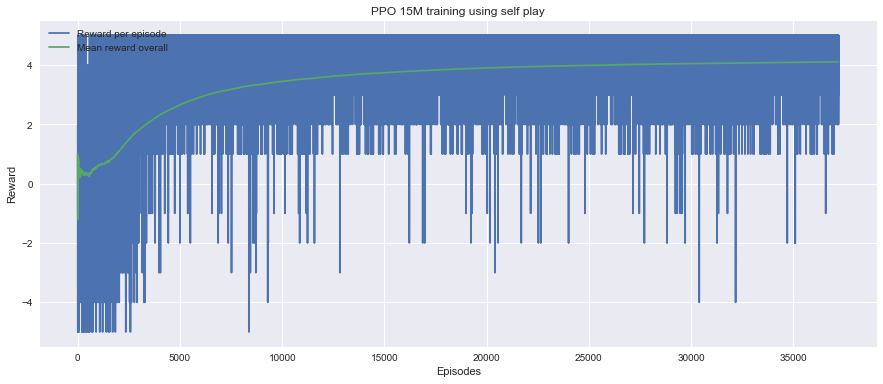

In [41]:
plot_sb_results(join('PPO', 'ppo15m_v2_train.monitor.csv'), 'PPO 15M training using self play')

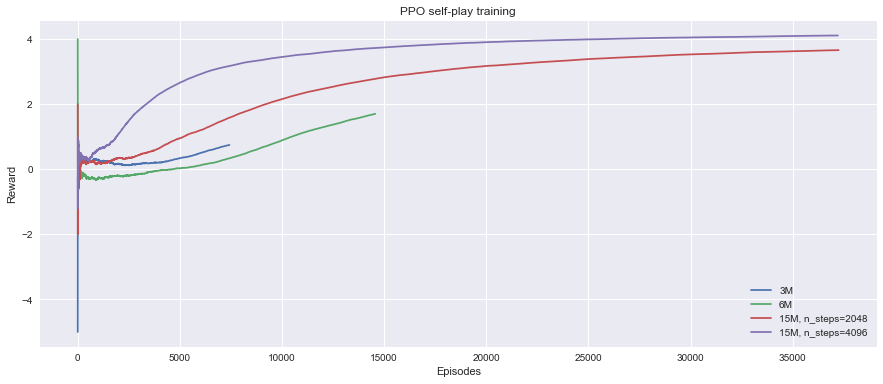

In [22]:
ppo_train1 = pd.read_csv(join(LOGDIR, 'PPO', 'ppo3m_train.monitor.csv'), skiprows=1).loc[:, 'r'].expanding().mean()
ppo_train2 = pd.read_csv(join(LOGDIR, 'PPO', 'ppo6m_train.monitor.csv'), skiprows=1).loc[:, 'r'].expanding().mean()
ppo_train3 = pd.read_csv(join(LOGDIR, 'PPO', 'ppo15m_v1_train.monitor.csv'), skiprows=1).loc[:, 'r'].expanding().mean()
ppo_train4 = pd.read_csv(join(LOGDIR, 'PPO', 'ppo15m_v2_train.monitor.csv'), skiprows=1).loc[:, 'r'].expanding().mean()
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(ppo_train1, label='3M')
ax.plot(ppo_train2, label='6M')
ax.plot(ppo_train3, label='15M, n_steps=2048')
ax.plot(ppo_train4, label='15M, n_steps=4096')
ax.set_xlabel('Episodes')
ax.set_ylabel('Reward')
ax.set_title('PPO self-play training')
ax.legend(loc='lower right');

plt.savefig(join(FIGDIR, 'PPO self-play training'), dpi=300, bbox_inches='tight')

#### Evaluation

In [ ]:
slime_env_gym = gym.make('SlimeVolley-v0')

ppo_policy = PPO.load(join(LOGDIR, 'PPO', 'history_00000148.zip'), env=slime_env_gym)
eval_rew, eval_len = evaluate_algorithm(slime_env_gym, ppo_policy, 1000)

In [13]:
save_results(eval_rew, eval_len, join('PPO', 'ppo_self_eval_15m_champ_v2.csv'))

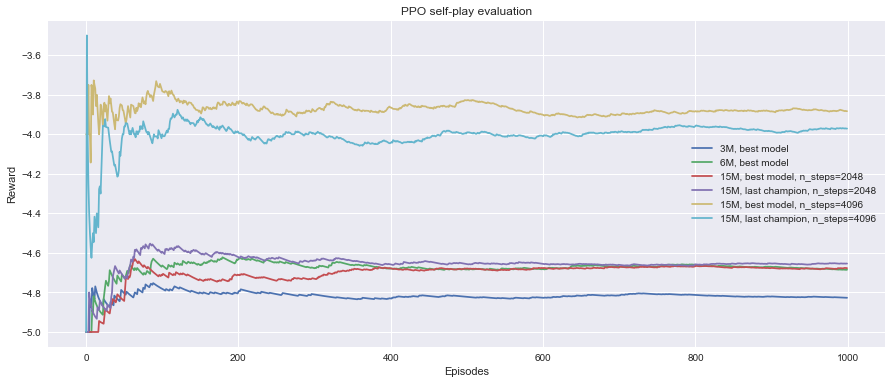

In [23]:
ppo_eval1 = pd.read_csv(join(LOGDIR, 'PPO', 'ppo_self_eval_3m.csv')).loc[:, 'eval_rewards'].expanding().mean()
ppo_eval2 = pd.read_csv(join(LOGDIR, 'PPO', 'ppo_self_eval_6m.csv')).loc[:, 'eval_rewards'].expanding().mean()
ppo_eval3 = pd.read_csv(join(LOGDIR, 'PPO', 'ppo_self_eval_15m.csv')).loc[:, 'eval_rewards'].expanding().mean()
ppo_eval4 = pd.read_csv(join(LOGDIR, 'PPO', 'ppo_self_eval_15m_champ.csv')).loc[:, 'eval_rewards'].expanding().mean()
ppo_eval5 = pd.read_csv(join(LOGDIR, 'PPO', 'ppo_self_eval_15m_v2.csv')).loc[:, 'eval_rewards'].expanding().mean()
ppo_eval6 = pd.read_csv(join(LOGDIR, 'PPO', 'ppo_self_eval_15m_champ_v2.csv')).loc[:, 'eval_rewards'].expanding().mean()
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(ppo_eval1, label='3M, best model')
ax.plot(ppo_eval2, label='6M, best model')
ax.plot(ppo_eval3, label='15M, best model, n_steps=2048')
ax.plot(ppo_eval4, label='15M, last champion, n_steps=2048')
ax.plot(ppo_eval5, label='15M, best model, n_steps=4096')
ax.plot(ppo_eval6, label='15M, last champion, n_steps=4096')
ax.set_xlabel('Episodes')
ax.set_ylabel('Reward')
ax.set_title('PPO self-play evaluation')
ax.legend();

plt.savefig(join(FIGDIR, 'PPO self-play evaluation'), dpi=300, bbox_inches='tight')

### DQN

#### Training

In [ ]:
env = Monitor(env=SlimeVolleySelfPlayEnv('DQN'),
              filename=join(LOGDIR, 'DQN', 'dqn15m_train'))

model = DQN('MlpPolicy', env, verbose=1)

eval_callback = SelfPlayCallback(eval_env=env,
                                 alg_name='DQN',
                                 best_model_save_path=join(LOGDIR, 'DQN'),
                                 log_path=join(LOGDIR, 'DQN'),
                                 eval_freq=EVAL_FREQ,
                                 n_eval_episodes=EVAL_EPISODES,
                                 deterministic=False)

model.learn(total_timesteps=15_000_000, callback=eval_callback)

model.save(join(LOGDIR, 'DQN', 'final_model'))

env.close()

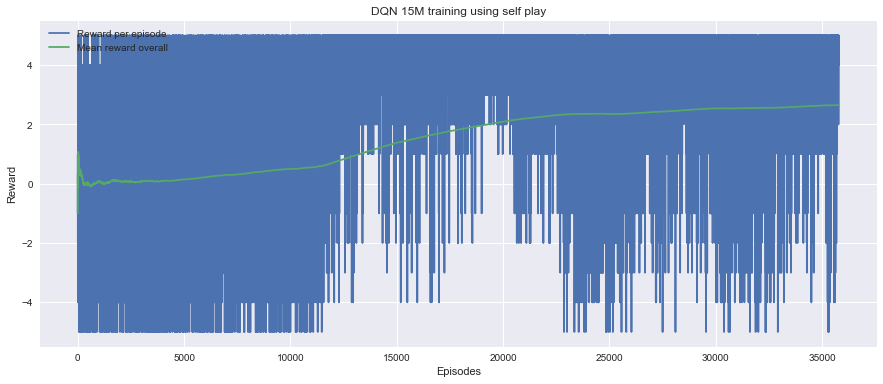

In [22]:
plot_sb_results(join('DQN', 'dqn15m_train.monitor.csv'), 'DQN 15M training using self play')

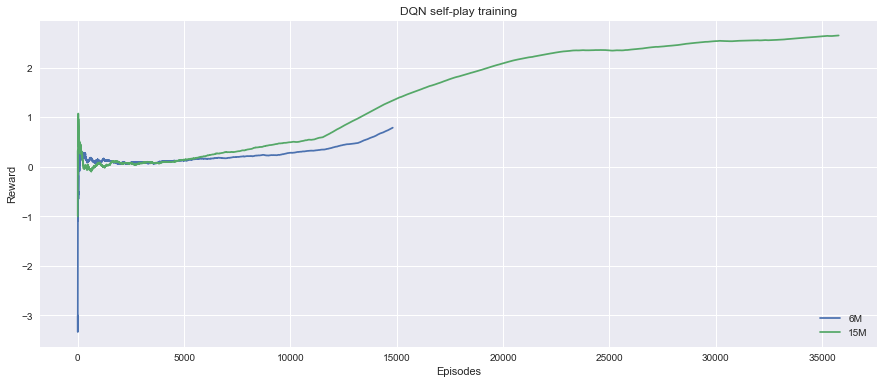

In [69]:
dqn_train1 = pd.read_csv(join(LOGDIR, 'DQN', 'dqn6m_train.monitor.csv'), skiprows=1).loc[:, 'r'].expanding().mean()
dqn_train2 = pd.read_csv(join(LOGDIR, 'DQN', 'dqn15m_train.monitor.csv'), skiprows=1).loc[:, 'r'].expanding().mean()
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(dqn_train1, label='6M')
ax.plot(dqn_train2, label='15M')
ax.set_xlabel('Episodes')
ax.set_ylabel('Reward')
ax.set_title('DQN self-play training')
ax.legend(loc='lower right');

#### Evaluation

In [ ]:
slime_env_gym = gym.make('SlimeVolley-v0')

ppo_policy = DQN.load(join(LOGDIR, 'DQN', 'history_00000126.zip'), env=slime_env_gym)
eval_rew, eval_len = evaluate_algorithm(slime_env_gym, ppo_policy, 1000)

In [43]:
save_results(eval_rew, eval_len, join('DQN', 'dqn_self_eval_champ_15m.csv'))

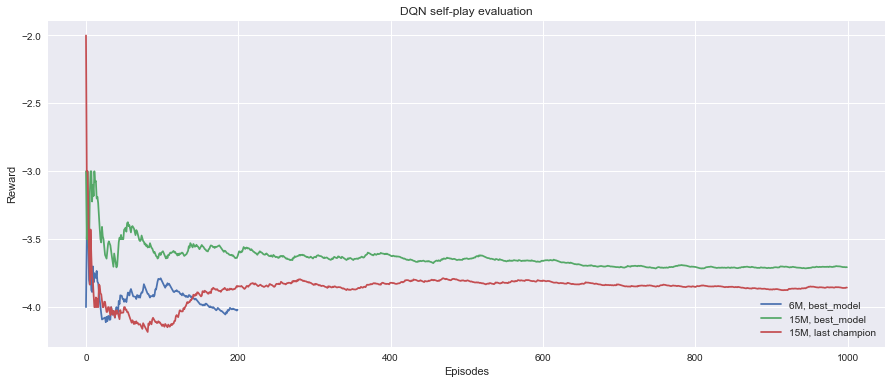

In [44]:
dqn_eval_1 = pd.read_csv(join(LOGDIR, 'DQN', 'dqn_self_eval_6m.csv')).loc[:, 'eval_rewards'].expanding().mean()
dqn_eval_2 = pd.read_csv(join(LOGDIR, 'DQN', 'dqn_self_eval_15m.csv')).loc[:, 'eval_rewards'].expanding().mean()
dqn_eval_3 = pd.read_csv(join(LOGDIR, 'DQN', 'dqn_self_eval_champ_15m.csv')).loc[:, 'eval_rewards'].expanding().mean()
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(dqn_eval_1, label='6M, best model')
ax.plot(dqn_eval_2, label='15M, best model')
ax.plot(dqn_eval_3, label='15M, last champion')
ax.set_xlabel('Episodes')
ax.set_ylabel('Reward')
ax.set_title('DQN self-play evaluation')
ax.legend(loc='lower right');

### SAC

#### Training

In [48]:
class DiscreteToBoxWrapper(gym.ActionWrapper):
    def __init__(self, env, new_action_set):
        super().__init__(env)
        self.new_action_set = new_action_set
        self.action_space = gym.spaces.Box(low=np.array([0, 1]), high=np.array([1, 5.999]))
        
    def action(self, box_act):
        if box_act[0] < 0.5:
            action = self.new_action_set[0]
        else:
            action = self.new_action_set[int(np.floor(box_act[1]))]
        return action

In [ ]:
action_table = [[0, 0, 0], # NOOP
                [1, 0, 0], # LEFT (forward)
                [1, 0, 1], # UPLEFT (forward jump)
                [0, 0, 1], # UP (jump)
                [0, 1, 1], # UPRIGHT (backward jump)
                [0, 1, 0]] # RIGHT (backward)

env = Monitor(env=DiscreteToBoxWrapper(SlimeVolleySelfPlayEnv('SAC'), action_table),
              filename=join(LOGDIR, 'SAC', 'sac2m_train'))

model = SAC('MlpPolicy', env, verbose=1)

eval_callback = SelfPlayCallback(eval_env=env,
                                 alg_name='SAC',
                                 best_model_save_path=join(LOGDIR, 'SAC'),
                                 log_path=join(LOGDIR, 'SAC'),
                                 eval_freq=EVAL_FREQ,
                                 n_eval_episodes=EVAL_EPISODES,
                                 deterministic=False)

model.learn(total_timesteps=2_000_000, callback=eval_callback)

model.save(join(LOGDIR, 'SAC', 'final_model'))

env.close()

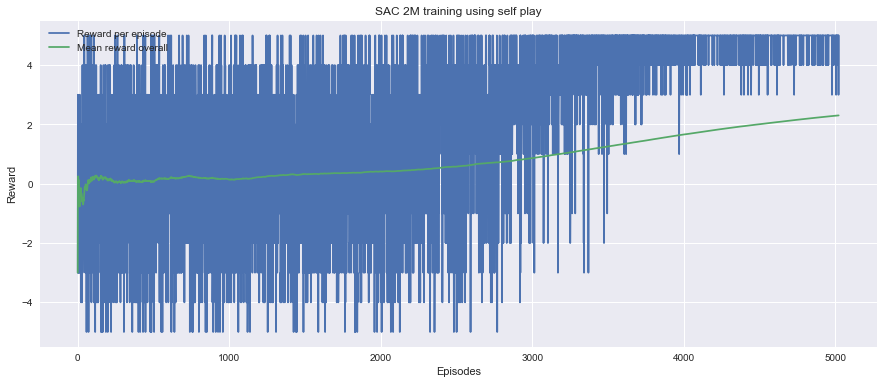

In [54]:
plot_sb_results(join('SAC', 'sac2m_train.monitor.csv'), 'SAC 2M training using self play')

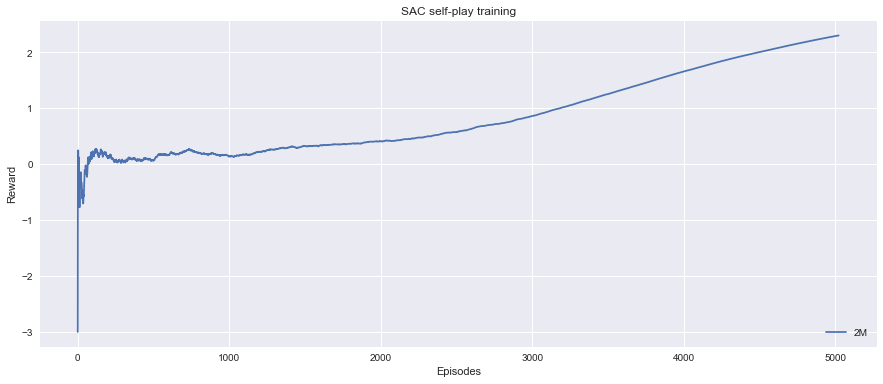

In [72]:
sac_train1 = pd.read_csv(join(LOGDIR, 'SAC', 'sac2m_train.monitor.csv'), skiprows=1).loc[:, 'r'].expanding().mean()
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(sac_train1, label='2M')
ax.set_xlabel('Episodes')
ax.set_ylabel('Reward')
ax.set_title('SAC self-play training')
ax.legend(loc='lower right');

#### Evaluation

In [ ]:
slime_env_gym = DiscreteToBoxWrapper(gym.make('SlimeVolley-v0'), action_table)

sac_policy = SAC.load(join(LOGDIR, 'SAC', 'history_00000016.zip'), env=slime_env_gym)
eval_rew, eval_len = evaluate_algorithm(slime_env_gym, sac_policy, 1000)

In [62]:
save_results(eval_rew, eval_len, join('SAC', 'sac_self_eval_2m_champ.csv'))

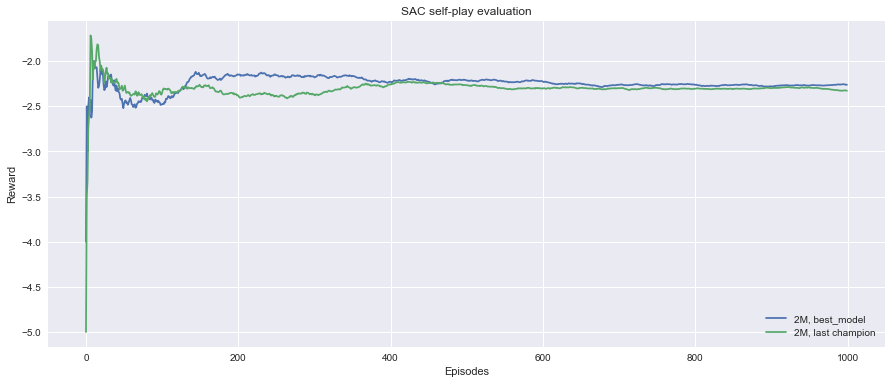

In [15]:
sac_eval_1 = pd.read_csv(join(LOGDIR, 'SAC', 'sac_self_eval_2m.csv')).loc[:, 'eval_rewards'].expanding().mean()
sac_eval_2 = pd.read_csv(join(LOGDIR, 'SAC', 'sac_self_eval_2m_champ.csv')).loc[:, 'eval_rewards'].expanding().mean()
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(sac_eval_1, label='2M, best model')
ax.plot(sac_eval_2, label='2M, last champion')
ax.set_xlabel('Episodes')
ax.set_ylabel('Reward')
ax.set_title('SAC self-play evaluation')
ax.legend(loc='lower right');

### Final results

#### Training

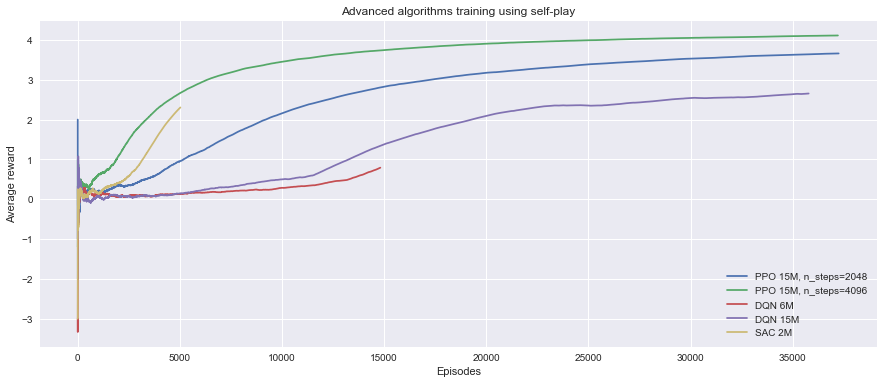

In [19]:
ppo_train1 = pd.read_csv(join(LOGDIR, 'PPO', 'ppo15m_v1_train.monitor.csv'), skiprows=1).loc[:, 'r'].expanding().mean()
ppo_train2 = pd.read_csv(join(LOGDIR, 'PPO', 'ppo15m_v2_train.monitor.csv'), skiprows=1).loc[:, 'r'].expanding().mean()
dqn_train1 = pd.read_csv(join(LOGDIR, 'DQN', 'dqn6m_train.monitor.csv'), skiprows=1).loc[:, 'r'].expanding().mean()
dqn_train2 = pd.read_csv(join(LOGDIR, 'DQN', 'dqn15m_train.monitor.csv'), skiprows=1).loc[:, 'r'].expanding().mean()
sac_train = pd.read_csv(join(LOGDIR, 'SAC', 'sac2m_train.monitor.csv'), skiprows=1).loc[:, 'r'].expanding().mean()
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(ppo_train1, label='PPO 15M, n_steps=2048')
ax.plot(ppo_train2, label='PPO 15M, n_steps=4096')
ax.plot(dqn_train1, label='DQN 6M')
ax.plot(dqn_train2, label='DQN 15M')
ax.plot(sac_train, label='SAC 2M')
ax.set_xlabel('Episodes')
ax.set_ylabel('Average reward')
ax.set_title('Advanced algorithms training using self-play')
ax.legend();

plt.savefig(join(FIGDIR, 'Advanced algorithms training using self-play.png'), dpi=300, bbox_inches='tight')

#### Evaluation

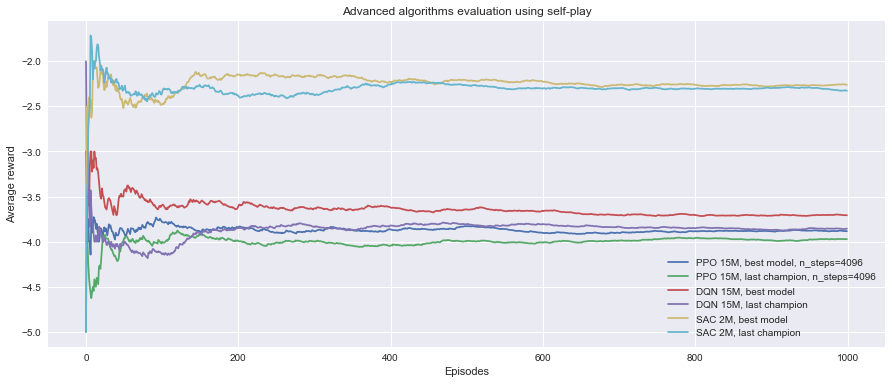

In [24]:
ppo_eval_1 = pd.read_csv(join(LOGDIR, 'PPO', 'ppo_self_eval_15m_v2.csv')).loc[:, 'eval_rewards'].expanding().mean()
ppo_eval_2 = pd.read_csv(join(LOGDIR, 'PPO', 'ppo_self_eval_15m_champ_v2.csv')).loc[:, 'eval_rewards'].expanding().mean()
dqn_eval_1 = pd.read_csv(join(LOGDIR, 'DQN', 'dqn_self_eval_15m.csv')).loc[:, 'eval_rewards'].expanding().mean()
dqn_eval_2 = pd.read_csv(join(LOGDIR, 'DQN', 'dqn_self_eval_champ_15m.csv')).loc[:, 'eval_rewards'].expanding().mean()
sac_eval_1 = pd.read_csv(join(LOGDIR, 'SAC', 'sac_self_eval_2m.csv')).loc[:, 'eval_rewards'].expanding().mean()
sac_eval_2 = pd.read_csv(join(LOGDIR, 'SAC', 'sac_self_eval_2m_champ.csv')).loc[:, 'eval_rewards'].expanding().mean()
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(ppo_eval_1, label='PPO 15M, best model, n_steps=4096')
ax.plot(ppo_eval_2, label='PPO 15M, last champion, n_steps=4096')
ax.plot(dqn_eval_1, label='DQN 15M, best model')
ax.plot(dqn_eval_2, label='DQN 15M, last champion')
ax.plot(sac_eval_1, label='SAC 2M, best model')
ax.plot(sac_eval_2, label='SAC 2M, last champion')
ax.set_xlabel('Episodes')
ax.set_ylabel('Average reward')
ax.set_title('Advanced algorithms evaluation using self-play')
ax.legend();

plt.savefig(join(FIGDIR, 'Advanced algorithms evaluation using self-play.png'), dpi=300, bbox_inches='tight')